In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "HuggingFaceTB/SmolLM-135M"  # HF model hub path
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",       # auto GPU/CPU mapping
    dtype="auto" )


c:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up pipeline/ response generator
from transformers import pipeline
from langchain.llms import HuggingFacePipeline

text_gen_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=1200,
    temperature=0.1
)

Device set to use cpu


In [ ]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os

folder_path = "crew_data" 
files = [f for f in os.listdir(folder_path)]

documents = []
for i, file in enumerate(files):   
    loader = PyPDFLoader(f"crew_data/{file}")
    doc = loader.load() 
    for d in doc:
        d.metadata["doc_id"] = i
        d.metadata["source"] = file
    documents.extend(doc)

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 2000, chunk_overlap = 290)
chunks = text_splitter.split_documents(documents)

Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)
Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 22 0 (offset 0)
Ignoring wrong pointing object 24 0 (offset 0)
Ignoring wrong pointing object 26 0 (offset 0)
Ignoring wrong pointing object 28 0 (offset 0)
Ignoring wrong pointing object 30 0 (offset 0)
Ignoring wrong pointing object 46 0 (offset 0)
Ignoring wrong pointing object 48 0 (offset 0)
Ignoring wrong pointing object 50 0 (offset 0)
Ignoring wrong pointing object 52 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 65 0 (offset 0)
Ignoring wrong pointing object 87 0 (offset 0)
Ignoring wrong pointing object 95 0 (offset 0)
Ignoring wrong pointing object 97 0 (offset 0)
Ignoring wrong

In [64]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

llm = HuggingFacePipeline(pipeline=text_gen_pipeline)
hf_embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Build vector store
vectorstore = FAISS.from_documents(chunks, hf_embedder)

In [88]:
# Build Search tool/retrieval
from langchain.chains import RetrievalQA

from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore

class Retriever:
    def __init__(self, vectorstore) -> RetrievalQA:
        self.retriever = vectorstore.as_retriever(search_type = "mmr", search_kwargs = {"k": 3}) 
        self.vectorstore = vectorstore
        self.docstore = InMemoryStore()
        self.doc_retriever = ParentDocumentRetriever(
            vectorstore = self.vectorstore,
            docstore = self.docstore,
            child_splitter= text_splitter
        )
    
        for i, d in enumerate(documents):
            d.metadata["doc_id"] = d.metadata.get("doc_id", f"doc_{i}")

        # Store parent docs in docstore
        self.docstore.mset([(d.metadata["doc_id"], d) for d in documents])
    
    def search_by_doc(self, query):
        return self.doc_retriever.get_relevant_documents(query)

class PDFSearchTool:
    def __init__(self, llm, retriever):
        "Answers questions about a PDF using document retrieval and an LLM."
        
        self.llm = llm
        self.retriever = retriever
        # Build the RetrievalQA chain
        self.qa_chain = RetrievalQA.from_chain_type(
            llm=self.llm,
            retriever=self.retriever.retriever,  
            chain_type="stuff"
        )

    def run(self, query: str) -> str:
        response = self.qa_chain(query)
        return response
    
retriever = Retriever(vectorstore)
pdf_tool = PDFSearchTool(llm=llm, retriever=retriever)

In [66]:
# Query the RAG tool 
pdf_tool.run("Describe a pyroelectric accelerator setup")

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


{'query': 'Describe a pyroelectric accelerator setup',
 'result': "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nother sources such as X-ray tubes or conventional accelerators. Together with the miniature dimensions and light weight, the pyroelectric accelerator has no external high voltage power supply or radioactive sources integrated. These peculiarities provide an opportunity to create simple, robust, mobile, and safe X-ray operation system for imaging and spectral applications. Deeper understanding of the pyroelectric generator enables us to reconsider the use of pyroelectric systems for nuclear research27,56,57. An additional bonus related to generation of strong electric fields and particles using electrification effects of solid volume dielectrics58,59 is revealed.   Methods Experimental layout in Fig. 1.  The pyroelectric crystal assembly (1) consisting of a 

In [92]:
# Use `.similarity_search()` to see what documents match a query.

# added methods for parentdocument retrieval to retriever class above
# example query
query = "What are the results of varying the temperature oscillation frequency?"
matching_docs = retriever.search_by_doc(query)
matching_chunks = vectorstore.similarity_search(query, k=3)  

print(matching_docs)
print(matching_chunks)

# inspect results
for i, doc in enumerate(matching_docs, 1): #enumerate starts from 1 instead of 0
    print(f"--- Document {i} (source: {doc.metadata['source']}) ---")
    print(doc.page_content[:500])  #preview first 500 characters

[Document(metadata={'producer': 'macOS Version 10.14.6 (Build 18G8022) Quartz PDFContext', 'creator': 'Word', 'creationdate': "D:20210401074439Z00'00'", 'title': 'Microsoft Word - Karataev_Pyro_Acc_V7.docx', 'moddate': "D:20210401074439Z00'00'", 'keywords': '', 'aapl:keywords': '[]', 'source': 'Karataev_Pyro_Acc_V7.pdf', 'total_pages': 7, 'page': 6, 'page_label': '7', 'doc_id': 1}, page_content='19 Brownridge, J.D., Raboy, S. Investigations of pyroelectric generation of x-rays. J. Appl. Phys. 86, 640-643 (1999).  20 Brownridge, J.D. X-ray fluoresced high-Z (up to Z=82) K x-rays produced by LiNbO3 and LiTaO3 pyroelectric crystal electron accelerators. Appl. Phys. Lett. 85, 1298-1304 (2004).  21 Geuther, J., Danon, Y. High-energy x-ray production with pyroelectric crystals. J. Appl. Phys. 97, 104916-104921 (2005).  22 Geuther, J. Radiation generation with pyroelectric crystals. PhD Thesis, (Rensselaer Polytechnic Institute, Troy, New York, 2007). 23 Fukao, S. et. al. Excitation of X-rays

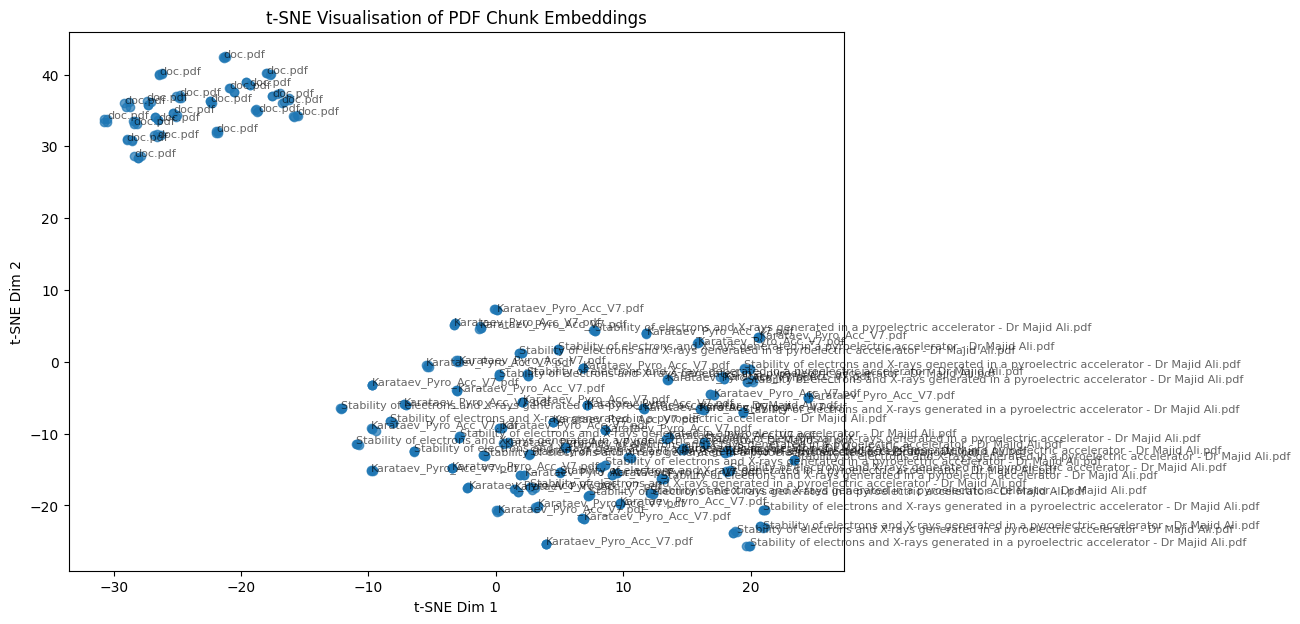

In [ ]:
# Visualize embeddings using PCA or t-SNE.
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

faiss_index = vectorstore.index
embeddings = np.array([faiss_index.reconstruct(i) for i in range(faiss_index.ntotal)])

pca = PCA(n_components=50)
pca_result = pca.fit_transform(embeddings)

# t-SNE to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_result = tsne.fit_transform(pca_result)


plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7)

sources = [doc.metadata.get("source", "unknown") for doc in chunks]
for i, source in enumerate(sources):
    plt.annotate(source, (tsne_result[i, 0], tsne_result[i, 1]), fontsize=8, alpha=0.6)

plt.title("t-SNE Visualisation of PDF Chunk Embeddings")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

In [79]:
from langchain_community.tools.tavily_search import TavilySearchResults
import getpass

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter Tavily API Key: ")

tavily_api_key = os.getenv("TAVILY_API_KEY")
# 🌐 Set up Tavily tool for real-time web search
web_search_tool = TavilySearchResults(k=3)

In [80]:
# 🔎 Run a web search using the Tavily tool
web_search_tool.run("What does Sporo Health do?")

[{'title': 'SPORO Health company information, funding & investors',
  'url': 'https://app.dealroom.co/companies/sporo_health',
  'content': "Sporo Health is a pioneering MedTech startup focused on revolutionizing healthcare through advanced generative AI solutions. The company operates in the healthcare technology market, specifically targeting clinicians and healthcare providers. Sporo Health's core product is an AI-driven platform that automates clinical workflows, allowing clinicians to focus more on personalized patient care rather than administrative tasks. By analyzing comprehensive patient data, the AI enables the creation of [...] personalized care plans and interactions, improving treatment outcomes and patient satisfaction. The platform also ensures data privacy and compliance through its advanced de-identification framework, safeguarding sensitive patient information. Sporo Health's business model involves partnering with healthcare institutions and leveraging strategic alli

In [93]:
from langchain.tools import tool

@tool
def router_tool(question):
  """Router Function"""
  if 'Sporo Health' in question:
    return 'vectorstore'
  else:
    return 'web_search'

In [100]:
from crewai import Agent, Crew, LLM

crewai_llm = LLM(model = "HuggingFaceTB/SmolLM-135M")

# An AI agent with a role and tools
Router_Agent = Agent(
  role='Router',
  goal='Route user question to a vectorstore or web search',
  backstory=(
    "You are an expert at routing a user question to a vectorstore or web search."
    "Use the vectorstore for questions on concept related to Retrieval-Augmented Generation."
    "You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use web-search."
  ),
  verbose=True,
  allow_delegation=False,
  llm=crewai_llm,
)

In [101]:
Retriever_Agent = Agent(
role="Retriever",
goal="Use the information retrieved from the vectorstore to answer the question",
backstory=(
    "You are an assistant for question-answering tasks."
    "Use the information present in the retrieved context to answer the question."
    "You have to provide a clear concise answer."
),
verbose=True,
allow_delegation=False,
llm=crewai_llm,
)

In [111]:
Researcher_Agent = Agent(
    role = "Researcher",
    goal = "Summarise key information from the uploaded documents",
    backstory = (
        "You are a precise and analytical researcher skilled at reading scientific papers." 
        "You identify the main objectives, methods, and conclusions, and answer user queries using the most relevant document evidence."
    ),
    verbose = True,
    allow_delegation = False,
    llm = crewai_llm,
)

In [112]:
Reporter_Agent = Agent(
    role = "Report Generator",
    goal = "Collects insights and exports them as a structured report (Markdown)",
    backstory = (
        "You are a meticulous research reporter who excels at transforming scattered findings into clear, structured narratives." 
        "Your writing balances technical accuracy with readability, ensuring that complex data becomes meaningful insight."
    ),
    verbose = True,
    allow_delegation = False,
    llm = crewai_llm,
)

In [ ]:
Grader_agent =  Agent(
  role='Answer Grader',
  goal='Filter out erroneous retrievals',
  backstory=(
    "You are a grader assessing relevance of a retrieved document to a user question."
    "If the document contains keywords related to the user question, grade it as relevant."
    "It does not need to be a stringent test.You have to make sure that the answer is relevant to the question."
  ),
  verbose=True,
  allow_delegation=False,
  llm= crewai_llm,
)

In [ ]:
hallucination_grader = Agent(
    role="Hallucination Grader",
    goal="Filter out hallucination",
    backstory=(
        "You are a hallucination grader assessing whether an answer is grounded in / supported by a set of facts."
        "Make sure you meticulously review the answer and check if the response provided is in alignmnet with the question asked"
    ),
    verbose=True,
    allow_delegation=False,
    llm= crewai_llm,
)

In [ ]:
answer_grader = Agent(
    role="Answer Grader",
    goal="Filter out hallucination from the answer.",
    backstory=(
        "You are a grader assessing whether an answer is useful to resolve a question."
        "Make sure you meticulously review the answer and check if it makes sense for the question asked"
        "If the answer is relevant generate a clear and concise response."
        "If the answer gnerated is not relevant then perform a websearch using 'web_search_tool'"
    ),
    verbose=True,
    allow_delegation=False,
    llm=crewai_llm,
)

In [ ]:
from crewai import Task

# Define the task each agent is responsible for
router_task = Task(
    description=("Analyse the keywords in the question {question}"
    "Based on the keywords decide whether it is eligible for a vectorstore search or a web search."
    "Return a single word 'vectorstore' if it is eligible for vectorstore search."
    "Return a single word 'websearch' if it is eligible for web search."
    "Do not provide any other premable or explaination."
    ),
    expected_output=("Give a binary choice 'websearch' or 'vectorstore' based on the question"
    "Do not provide any other premable or explaination."),
    agent=Router_Agent,
    tools=[router_tool],
)

ValidationError: 1 validation error for Task
tools.0
  Input should be a valid dictionary or instance of BaseTool [type=model_type, input_value=StructuredTool(name='rout... at 0x0000025C9257FCE0>), input_type=StructuredTool]
    For further information visit https://errors.pydantic.dev/2.12/v/model_type

In [ ]:
# 🧩 Define the task each agent is responsible for
retriever_task = Task(
    description=("Based on the response from the router task extract information for the question {question} with the help of the respective tool."
    "Use the web_serach_tool to retrieve information from the web in case the router task output is 'websearch'."
    "Use the rag_tool to retrieve information from the vectorstore in case the router task output is 'vectorstore'."
    ),
    expected_output=("You should analyse the output of the 'router_task'"
    "If the response is 'websearch' then use the web_search_tool to retrieve information from the web."
    "If the response is 'vectorstore' then use the rag_tool to retrieve information from the vectorstore."
    "Return a claer and consise text as response."),
    agent=Retriever_Agent,
    context=[router_task],
   #tools=[retriever_tool],
)

In [ ]:
# 🧩 Define the task each agent is responsible for
grader_task = Task(
    description=("Based on the response from the retriever task for the quetion {question} evaluate whether the retrieved content is relevant to the question."
    ),
    expected_output=("Binary score 'yes' or 'no' score to indicate whether the document is relevant to the question"
    "You must answer 'yes' if the response from the 'retriever_task' is in alignment with the question asked."
    "You must answer 'no' if the response from the 'retriever_task' is not in alignment with the question asked."
    "Do not provide any preamble or explanations except for 'yes' or 'no'."),
    agent=Grader_agent,
    context=[retriever_task],
)

In [ ]:
researcher_task = Task(
    description = ()
    expected_output = ()
    agent = Researcher_Agent,
    context = [retriever_task],
)

In [ ]:
reporter_task = Task(
    description= (),
    expected_output = (),
    agent = Reporter_Agent,
    context = [retriever_task],
)

In [ ]:
# 🧩 Define the task each agent is responsible for
hallucination_task = Task(
    description=("Based on the response from the grader task for the quetion {question} evaluate whether the answer is grounded in / supported by a set of facts."),
    expected_output=("Binary score 'yes' or 'no' score to indicate whether the answer is sync with the question asked"
    "Respond 'yes' if the answer is in useful and contains fact about the question asked."
    "Respond 'no' if the answer is not useful and does not contains fact about the question asked."
    "Do not provide any preamble or explanations except for 'yes' or 'no'."),
    agent=hallucination_grader,
    context=[grader_task],
)

# 🧩 Define the task each agent is responsible for
answer_task = Task(
    description=("Based on the response from the hallucination task for the quetion {question} evaluate whether the answer is useful to resolve the question."
    "If the answer is 'yes' return a clear and concise answer."
    "If the answer is 'no' then perform a 'websearch' and return the response"),
    expected_output=("Return a clear and concise response if the response from 'hallucination_task' is 'yes'."
    "Perform a web search using 'web_search_tool' and return ta clear and concise response only if the response from 'hallucination_task' is 'no'."
    "Otherwise respond as 'Sorry! unable to find a valid response'."),
    context=[hallucination_task],
    agent=answer_grader,
    #tools=[answer_grader_tool],
)

In [ ]:
# 👥 Assemble agents into a Crew to collaborate on the task
rag_crew = Crew(
    agents=[Router_Agent, Retriever_Agent, Grader_agent, hallucination_grader, answer_grader],
    tasks=[router_task, retriever_task, grader_task, hallucination_task, answer_task],
    verbose=True,

)

In [ ]:
inputs ={"question":"Does Sporo Streamline patient chart reviews?"}

In [ ]:
# ▶️ Start the collaborative process among the agents
result = rag_crew.kickoff(inputs=inputs)

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 9c0b12f0-afc2-4c3c-847b-d9e9994033be                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Router                                                                                                  │
│                                                                                                                 │
│  Task: Analyse the keywords in the question Does Sporo Streamline patient chart reviews?Based on the keywords   │
│  decide whether it is eligible for a vectorstore search or a web search.Return a single word 'vectorstore' if   │
│  it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do     │
│  not provide any other premable or explaination.                                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── LLM Error ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  ❌ LLM Call Failed                                                                                             │
│  Error: litellm.BadRequestError: LLM Provider NOT provided. Pass in the LLM provider you are trying to call.    │
│  You passed model=HuggingFacePipeline                                                                     │
│  Params: {'model_id': 'gpt2', 'model_kwargs': None, 'pipeline_kwargs': None}                                    │
│   Pass model as E.g. For 'Huggingface' inference endpoints pass in                                              │
│  `completion(model='huggingface/starcoder',..)` Learn more: https://docs.litellm.ai/docs/providers              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── Task Failure ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Failed                                                                                                    │
│  Name: 1a35f216-7350-46f6-8ecc-eb13607149f5                                                                     │
│  Agent: Router                                                                                                  │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── Crew Failure ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Failed                                                                                          │
│  Name: crew                                                                                                     │
│  ID: 9c0b12f0-afc2-4c3c-847b-d9e9994033be                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output:                                                                                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Execution Traces ────────────────────────────────────────────────╮
│                                                                                                                 │
│  🔍 Detailed execution traces are available!                                                                    │
│                                                                                                                 │
│  View insights including:                                                                                       │
│    • Agent decision-making process                                                                              │
│    • Task execution flow and timing                                                                             │
│    • Tool usage details                                                                                         │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Would you like to view your execution traces? [y/N] (20s timeout): 

BadRequestError: litellm.BadRequestError: LLM Provider NOT provided. Pass in the LLM provider you are trying to call. You passed model=[1mHuggingFacePipeline[0m
Params: {'model_id': 'gpt2', 'model_kwargs': None, 'pipeline_kwargs': None}
 Pass model as E.g. For 'Huggingface' inference endpoints pass in `completion(model='huggingface/starcoder',..)` Learn more: https://docs.litellm.ai/docs/providers

In [ ]:
print(result)

Yes, Sporo Streamline patient chart reviews.
